In [1]:
from math import sqrt, ceil
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
data = pd.read_csv('../data/student-por.csv')

In [3]:
plt.style.use("dark_background")

In [4]:
Y = data[['G1', 'G2', 'G3']].sum(axis=1)
X = data.drop(['G1', 'G2', 'G3'], axis=1)
X = (X - X.min()) / (X.max() - X.min())
Y = Y.apply(lambda x: 1 if x > 36 else 0)

In [5]:
random_state = 9527

pca_1d = PCA(15, random_state=random_state)
L_sk = pca_1d.fit_transform(X)
print(pca_1d.explained_variance_ratio_)
print('L_sk.shape:', L_sk.shape)
print('L_sk:', L_sk[:, :4])


[0.11397246 0.09177979 0.07526411 0.06875526 0.06262613 0.06071489
 0.0498503  0.04426735 0.04270601 0.03919675 0.03729149 0.03354056
 0.03132639 0.02914474 0.02475502]
L_sk.shape: (649, 15)
L_sk: [[ 0.15694681 -0.55898024 -0.78419413  0.29488769]
 [ 0.06706346 -0.76053984 -0.4263281  -0.12175133]
 [-0.04446017 -0.25665235 -0.91904688  0.45874699]
 ...
 [ 0.77200794 -0.02178038 -0.02007369  0.04254561]
 [ 0.20514191  1.05791171 -0.87295291  0.34058107]
 [ 0.61510887  1.2109193  -0.7253179  -0.10288083]]


In [6]:
pca_1d.components_[0]

array([ 0.55317137, -0.24006239,  0.04349504, -0.4186469 , -0.03927909,
        0.00533468, -0.2494163 , -0.19959923, -0.23733542, -0.05112797,
       -0.14334082,  0.01188203,  0.15751002, -0.0614817 ,  0.06038373,
       -0.03423993, -0.12172509, -0.0269322 , -0.24660833, -0.04421349,
       -0.12526214, -0.34879621,  0.13979958, -0.0327064 , -0.02073669,
       -0.02381438, -0.01134913, -0.04390328, -0.05218859, -0.02244829])

In [7]:
print(Y.value_counts())

0    373
1    276
Name: count, dtype: int64


In [8]:
def knn_thing(L_sk, Y, log_data, ratio=.2, rs=42):
    curr_best_report = None
    curr_best_k = None
    best_f1 = 0
    for i in range(1, ceil(sqrt(len(L_sk)))):
        X_train, X_test, y_train, y_test = train_test_split(L_sk, Y, test_size=ratio, random_state=rs)
        # Feature scaling (optional but recommended for KNN)

        knn = KNeighborsClassifier(n_neighbors=i)

        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)

        if f1 > best_f1:
            best_f1 = f1
            curr_best_report = classification_report(y_test, y_pred)
            curr_best_k = i
        log_data.append({'k': i, 'F1 Score': f1, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall})

    log_df = pd.DataFrame(log_data)
    log_df.to_csv(f'../reports/pca_then_knn_{ratio}.csv', index=False)
    print(f"Best K: {curr_best_k}")
    print(curr_best_report)

In [9]:
def plot_log(log_df, title='Performance Metrics vs. k(With PCA)'):
    plt.figure(figsize=(10, 6))
    plt.plot(log_df['k'], log_df['F1 Score'], label='F1 Score')
    plt.plot(log_df['k'], log_df['Accuracy'], label='Accuracy')
    plt.plot(log_df['k'], log_df['Precision'], label='Precision')
    plt.plot(log_df['k'], log_df['Recall'], label='Recall')

    plt.xlabel('k')
    plt.ylabel('value')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.ylim(0.35, 0.8)
    ratio = title.split(' ')[-1]
    ratio = ratio[0:1] + '_' + ratio[2:]
    filename = '../plots/pca_then_knn_' + ratio.split(':')[0] + '.png'
    plt.savefig(filename)
    plt.show()

Best K: 21
              precision    recall  f1-score   support

           0       0.68      0.61      0.65        70
           1       0.60      0.67      0.63        60

    accuracy                           0.64       130
   macro avg       0.64      0.64      0.64       130
weighted avg       0.64      0.64      0.64       130


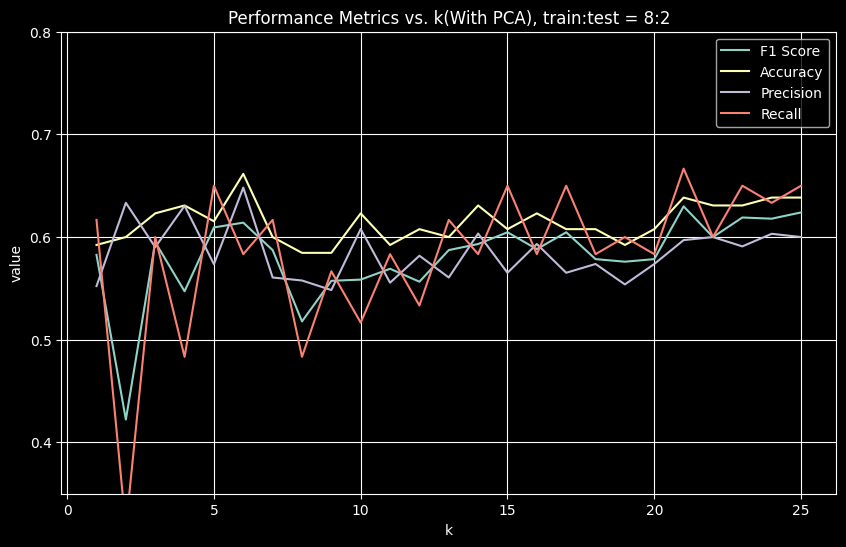

CPU times: total: 31.2 ms
Wall time: 391 ms


In [10]:
%%time
## KNN with train:test = 8:2
log_data = []
knn_thing(L_sk, Y, log_data)
plot_log(pd.DataFrame(log_data), title='Performance Metrics vs. k(With PCA), train:test = 8:2')

Best K: 25
              precision    recall  f1-score   support

           0       0.76      0.59      0.66       110
           1       0.59      0.75      0.66        85

    accuracy                           0.66       195
   macro avg       0.67      0.67      0.66       195
weighted avg       0.68      0.66      0.66       195


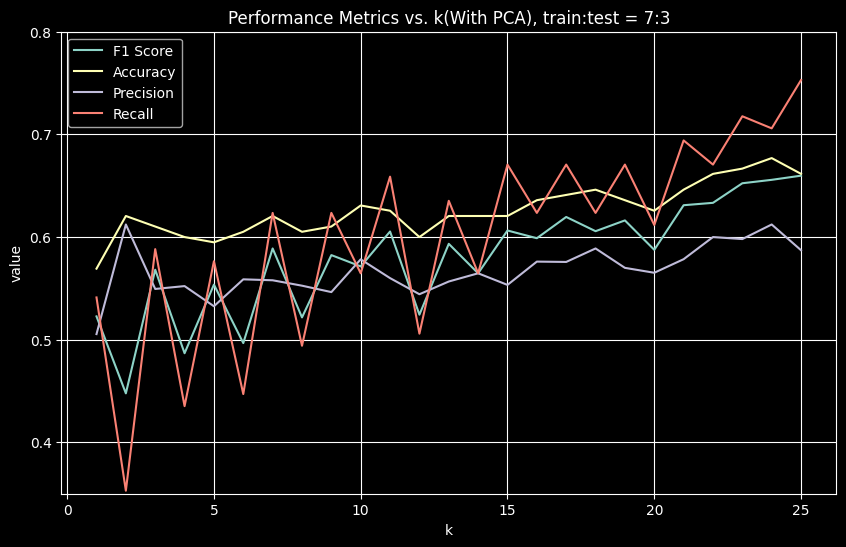

CPU times: total: 46.9 ms
Wall time: 457 ms


In [11]:
%%time
## KNN with train:test = 7:3
log_data = []
knn_thing(L_sk, Y, log_data, ratio=.3)
plot_log(pd.DataFrame(log_data), title='Performance Metrics vs. k(With PCA), train:test = 7:3')